# Baseline

## Set-up
- Download the [Epileptic Seizure Recognition Data Set](http://archive.ics.uci.edu/ml/datasets/Epileptic+Seizure+Recognition) and place it in the current directory.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import util

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

## Data
We generate a dataset with the minimum and standard deviation of a given individual's activity as our two features, using a 80/20 train/test split.

In [2]:
X, y = util.parse_data()
n = X.shape[0]
classes = np.unique(y)

In [3]:
X = np.concatenate((np.amin(X, axis=1).reshape(n, 1), np.std(X, axis=1).reshape(n, 1)), axis=1)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

## Model
For our baseline, we use a softmax classifier.

In [5]:
clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc = clf.score(X_test, y_test)
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_per_class = f1_score(y_test, y_pred, average=None, labels=classes)
cm = confusion_matrix(y_test, y_pred)

print('Acc:', acc)
print('Macro F1:', f1_macro)
print('F1 Score by Class:', f1_per_class)

Acc: 0.41
Macro F1: 0.41654359975403654
F1 Score by Class: [0.91891892 0.23255814 0.22222222 0.24390244 0.46511628]


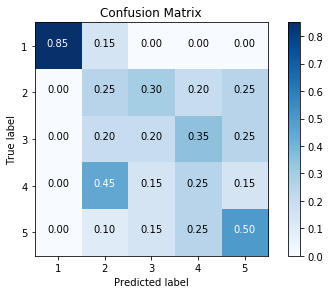

In [6]:
util.visualize_confusion_matrix(cm, classes)

We plot the points.

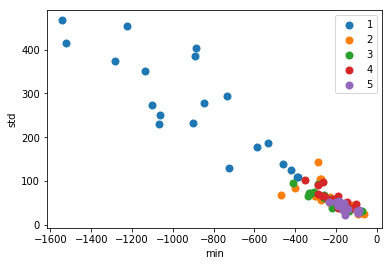

In [7]:
plt.figure()
for c in classes:
    plt.scatter(X_test[y_test == c, 0], X_test[y_test == c, 1], linewidth=2, label=str(c))
plt.xlabel('min')
plt.ylabel('std')
plt.legend()
plt.show()